## Precompute Features
  
This notebook shows how to compute an initial feature representation (Harmonic Constant-Q Transform or HCQT) from an audio file and how to convert multi-pitch annotations from a csv list of note events to an output representation for training multi-pitch estimators.

&copy; Christof Weiss and Geoffroy Peeters, Télécom Paris 2021

In [1]:
import os
import sys
basepath = os.path.abspath(os.path.dirname(os.path.dirname('.')))
sys.path.append(basepath)
import numpy as np, os, scipy, scipy.spatial, matplotlib.pyplot as plt, IPython.display as ipd
from numba import jit
import librosa
import libfmp.b, libfmp.c3, libfmp.c5
import pandas as pd, pickle, re
from numba import jit
from libdl.data_preprocessing import compute_hopsize_cqt, compute_hcqt, compute_efficient_hcqt, compute_annotation_array_nooverlap

### 1. Load audio

Load an audio file from the [Schubert Winterreise Dataset](https://doi.org/10.5281/zenodo.5139893). This serves to illustrate the extracted representations, corresponding to the following score example (Song 23 from _Winterreise_, please note that the version sung by R. Scarlata (SC06) is two semitones lower):

<img src="data/Schubert_Winterreise/score_example.png" width="500" align="left"/>

In [2]:
fs = 22050
audio_folder = os.path.join(basepath, 'data', 'Schubert_Winterreise', 'audio_wav')

# fn_audio = 'Schubert_D911-02_HU33.wav'
# fn_audio = 'Schubert_D911-02_SC06.wav'
# fn_audio = 'Schubert_D911-23_HU33.wav'
fn_audio = 'Schubert_D911-23_SC06.wav'

path_audio = os.path.join(audio_folder, fn_audio)
f_audio, fs_load = librosa.load(path_audio, sr=fs)

### 2. Compute HCQT representation and plot its channels

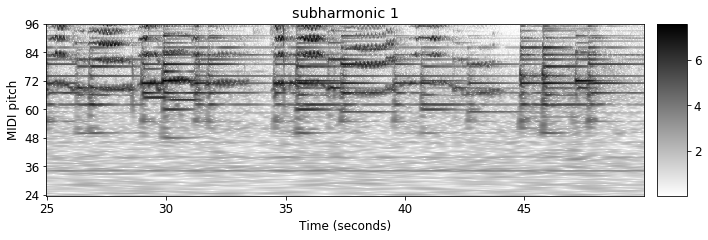

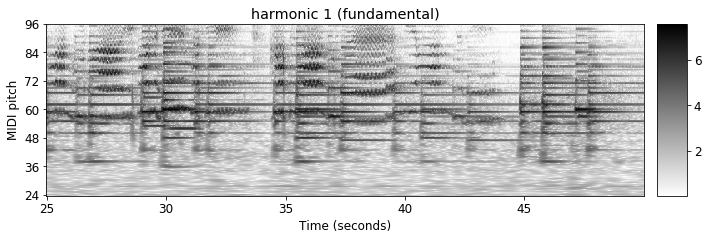

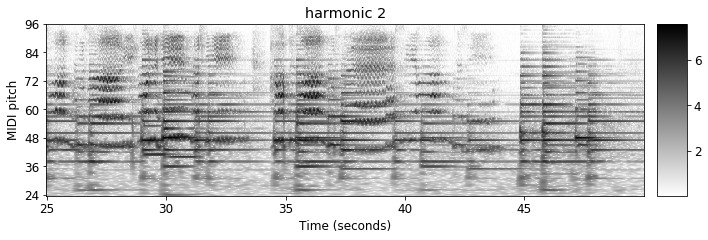

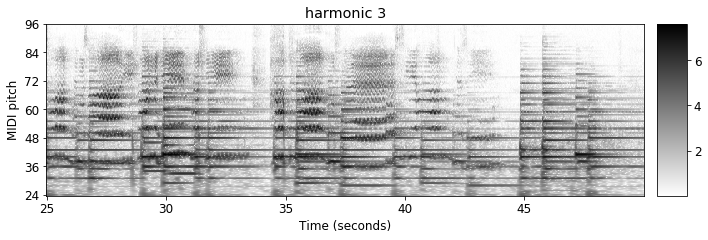

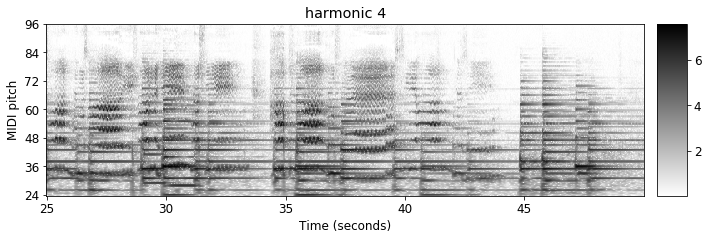

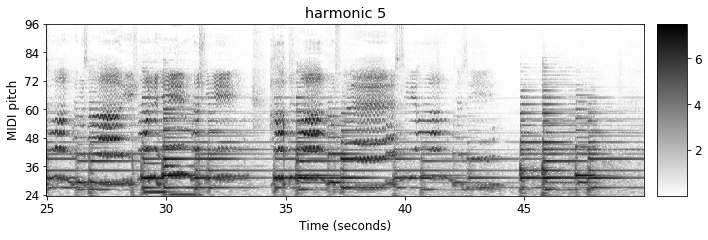

In [3]:
bins_per_semitone = 3
num_octaves = 6
n_bins = bins_per_semitone*12*num_octaves
num_harmonics = 5
num_subharmonics = 1

f_hcqt, fs_hcqt, hopsize_cqt = compute_efficient_hcqt(f_audio, fs=22050, fmin=librosa.note_to_hz('C1'), fs_hcqt_target=50, \
                                                    bins_per_octave=bins_per_semitone*12, num_octaves=num_octaves, \
                                                    num_harmonics=num_harmonics, num_subharmonics=num_subharmonics)

start_sec = 25
show_sec = 50

for curr_ax in range(0, 6):
    plt.rcParams.update({'font.size': 12})
    fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 0.05]}, figsize=(10, 3.5))
    im = libfmp.b.plot_matrix(np.log(1+1000*np.abs(f_hcqt[:, int(start_sec*fs_hcqt):int(show_sec*fs_hcqt), curr_ax])), Fs=fs_hcqt, ax=ax, cmap='gray_r', ylabel='MIDI pitch')
    ax[0].set_yticks(np.arange(1, n_bins+13, 12*bins_per_semitone))
    ax[0].set_yticklabels([str(24+12*octave) for octave in range(0, num_octaves+2)])
    ax[0].set_xticklabels(np.arange(start_sec-5, show_sec+5, 5))
    if curr_ax==0:
        ax[0].set_title('subharmonic 1')
    elif curr_ax==1:
        ax[0].set_title('harmonic 1 (fundamental)')
    else:
        ax[0].set_title('harmonic ' + str(curr_ax))
    plt.tight_layout()
    
    
### Optional: Save ###
# path_output = ''
# np.save(os.path.join(path_output, fn_audio[:-4]+'.npy'), f_hcqt)

### 3. Load annotations and convert to numpy array

In [4]:
annot_folder = os.path.join(basepath, 'data', 'Schubert_Winterreise', 'ann_audio_note')
fn_annot = os.path.join(annot_folder, fn_audio[:-4]+'.csv')

df = pd.read_csv(fn_annot, sep=';', skiprows=1, header=None)
note_events = df.to_numpy()[:, :3]
        
f_annot_pitch = compute_annotation_array_nooverlap(note_events.copy(), f_hcqt, fs_hcqt, annot_type='pitch', shorten=1.0)

### 4. Plot annotation array

In [5]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 0.05]}, figsize=(10, 3.5))

cfig, cax, cim = libfmp.b.plot_matrix(f_annot_pitch[24:97, int(start_sec*fs_hcqt):int(show_sec*fs_hcqt)], ax=ax, Fs=fs_hcqt, cmap='gray_r', ylabel='MIDI pitch')
plt.ylim([0, 73])
ax[0].set_yticks(np.arange(0, 73, 12))
ax[0].set_yticklabels([str(24+12*octave) for octave in range(0, num_octaves+1)])
ax[0].set_title('Multi-pitch annotations (piano roll)')
ax[1].set_ylim([0, 1])
plt.tight_layout()

### Optional: Save ###
# path_output_annot = ''
# np.save(os.path.join(path_output_annot, song_fn_wav[:-4]+'.npy'), f_annot_pitch)

### 5. Plot sequence of non-repeating annotation vectors (as used for MCTC training)

In [6]:
from itertools import groupby

feat_score = (f_annot_pitch[:, int(start_sec*fs_hcqt):int(show_sec*fs_hcqt)]>0.5).astype(int)

char_unique, char_target = np.unique(feat_score, axis=1, return_inverse=True)   # char_unique is the BatchCharacterList
char_targ_condensed = np.array([t[0] for t in groupby(char_target)])

featvec = np.zeros((12, 0))
feat_score_compressed = np.array([char_unique[:, t] for t in char_targ_condensed]).T

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 0.05]}, figsize=(10, 3.5))

libfmp.b.plot_matrix(feat_score_compressed[24:97, :], ax=ax, Fs=1, cmap='gray_r', ylabel='MIDI pitch')
ax[0].set_xlabel('')
ax[0].set_xticks(np.arange(.5, 35.5, 1))
ax[0].set_xticklabels('')
ax[0].xaxis.grid('on')
ax[1].set_ylim([0, 1])
plt.ylim([0, 73])
ax[0].set_yticks(np.arange(0, 73, 12))
ax[0].set_yticklabels([str(24+12*octave) for octave in range(0, num_octaves+1)])
ax[0].set_title('Non-repeating targets (for MCTC)')
ax[1].set_ylim([0, 1])
plt.tight_layout()